<a href="https://colab.research.google.com/github/Anwarshamim01/Anamoly-Detection-in-Google-Cluster-powerdata-2019-trace-dataset/blob/main/Anamoly_Detection_in_Google_Cluster_powerdata_2019_trace_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import altair as alt
import numpy as np
import pandas as pd
from google.cloud import bigquery
from google.colab import auth
from google.cloud.bigquery import magics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import glob
import re
import os

auth.authenticate_user()
print('Authenticated')
client = bigquery.Client(project='wazir-analysis')


# **IN This notebook , i processed data for ML models and applied them**
I used Transformer variant for time series . I trained model on simgle feaure and multifeatures . AS it is shown in EDA notebook that power_util and 'measured_power_util', 'measured_power_util_lag_1', 'measured_power_util_lag_2',
    'measured_power_util_lag_3', 'measured_power_util_roll_mean',
    'measured_power_util_roll_std', 'hour', 'day_of_week'



In [ ]:
!gsutil ls gs://powerdata_2019/


gs://powerdata_2019/cella_pdu10.csv.gz
gs://powerdata_2019/cella_pdu6.csv.gz
gs://powerdata_2019/cella_pdu7.csv.gz
gs://powerdata_2019/cella_pdu8.csv.gz
gs://powerdata_2019/cella_pdu9.csv.gz
gs://powerdata_2019/cellb_pdu11.csv.gz
gs://powerdata_2019/cellb_pdu12.csv.gz
gs://powerdata_2019/cellb_pdu13.csv.gz
gs://powerdata_2019/cellb_pdu14.csv.gz
gs://powerdata_2019/cellb_pdu15.csv.gz
gs://powerdata_2019/cellc_pdu38.csv.gz
gs://powerdata_2019/cellc_pdu39.csv.gz
gs://powerdata_2019/cellc_pdu40.csv.gz
gs://powerdata_2019/cellc_pdu41.csv.gz
gs://powerdata_2019/cellc_pdu42.csv.gz
gs://powerdata_2019/cellc_pdu43.csv.gz
gs://powerdata_2019/celld_pdu32.csv.gz
gs://powerdata_2019/celld_pdu33.csv.gz
gs://powerdata_2019/celld_pdu34.csv.gz
gs://powerdata_2019/celld_pdu35.csv.gz
gs://powerdata_2019/celld_pdu36.csv.gz
gs://powerdata_2019/celld_pdu37.csv.gz
gs://powerdata_2019/celle_pdu26.csv.gz
gs://powerdata_2019/celle_pdu27.csv.gz
gs://powerdata_2019/celle_pdu28.csv.gz
gs://powerdata_2019/celle_pdu

In [ ]:

import os
data_dir = '/content/powerdata_2019/'
os.makedirs(data_dir, exist_ok=True)


In [ ]:

%cd /content/powerdata_2019/

!gsutil -m cp gs://powerdata_2019/cell[a-j]_pdu*.csv.gz .
!gsutil -m cp gs://powerdata_2019/cell[i-j]_mvpp*.csv.gz .

!gsutil cp gs://powerdata_2019/machine_to_pdu_mapping.csv.gz .


/content/powerdata_2019
Copying gs://powerdata_2019/cellb_pdu11.csv.gz...
Copying gs://powerdata_2019/cella_pdu6.csv.gz...
Copying gs://powerdata_2019/cella_pdu10.csv.gz...
Copying gs://powerdata_2019/cella_pdu7.csv.gz...
Copying gs://powerdata_2019/cellb_pdu13.csv.gz...
Copying gs://powerdata_2019/cellb_pdu14.csv.gz...
Copying gs://powerdata_2019/cellb_pdu15.csv.gz...
Copying gs://powerdata_2019/cella_pdu8.csv.gz...
Copying gs://powerdata_2019/cella_pdu9.csv.gz...
Copying gs://powerdata_2019/cellb_pdu12.csv.gz...
Copying gs://powerdata_2019/cellc_pdu38.csv.gz...
Copying gs://powerdata_2019/cellc_pdu39.csv.gz...
Copying gs://powerdata_2019/cellc_pdu40.csv.gz...
Copying gs://powerdata_2019/cellc_pdu41.csv.gz...
Copying gs://powerdata_2019/cellc_pdu42.csv.gz...
Copying gs://powerdata_2019/cellc_pdu43.csv.gz...
Copying gs://powerdata_2019/celld_pdu32.csv.gz...
Copying gs://powerdata_2019/celld_pdu33.csv.gz...
Copying gs://powerdata_2019/celld_pdu35.csv.gz...
Copying gs://powerdata_2019/ce

In [ ]:

!gunzip *.csv.gz



gzip: cella_pdu10.csv already exists; do you wish to overwrite (y or n)? ^C


In [ ]:


trace_start_time_pt = pd.Timestamp('2019-05-01 00:00:00', tz='America/Los_Angeles')


In [ ]:

trace_start_time_utc = trace_start_time_pt.tz_convert('UTC')
print('Trace start time in UTC:', trace_start_time_utc)


Trace start time in UTC: 2019-05-01 07:00:00+00:00


In [ ]:
# T0 is 10 minutes before the trace start time
T0 = trace_start_time_utc - pd.Timedelta(minutes=10)
print('Reference time (T0) in UTC:', T0)


Reference time (T0) in UTC: 2019-05-01 06:50:00+00:00


In [ ]:


def get_power_utilization_data():
    data_dir = '/content/powerdata_2019/'
    csv_files = glob.glob(os.path.join(data_dir, 'cell[a-j]_*.csv'))

    df_list = []

    for file in csv_files:
        filename = os.path.basename(file)
        match = re.match(r'cell([a-j])_(pdu|mvpp)(\d+)\.csv', filename)
        if match:
            cell = match.group(1)
            pdu_type = match.group(2)
            pdu_number = match.group(3)
            pdu = pdu_type + pdu_number

            df = pd.read_csv(file)

            df['cell'] = cell
            df['pdu'] = pdu

            df = df[
                (df['bad_measurement_data'] == False) &
                (df['bad_production_power_data'] == False)
            ]

            df_list.append(df)

    power_data = pd.concat(df_list, ignore_index=True)

    trace_start_time_pt = pd.Timestamp('2019-05-01 00:00:00', tz='America/Los_Angeles')

    trace_start_time_utc = trace_start_time_pt.tz_convert('UTC')

    T0 = trace_start_time_utc - pd.Timedelta(minutes=10)
    power_data['time_delta'] = pd.to_timedelta(power_data['time'], unit='us')

    power_data['time'] = T0 + power_data['time_delta']

    power_data.drop(columns=['time_delta'], inplace=True)

    power_data['time'] = power_data['time'].dt.tz_convert(None)

    power_data = power_data.sort_values('time').reset_index(drop=True)

    return power_data
power_data = get_power_utilization_data()
print('Power utilization data retrieved:', power_data.shape)

print(power_data[['time', 'cell', 'pdu', 'measured_power_util']].head())


Power utilization data retrieved: (392364, 7)
                 time cell    pdu  measured_power_util
0 2019-05-01 07:00:00    h  pdu55                0.560
1 2019-05-01 07:00:00    h  pdu46                0.534
2 2019-05-01 07:00:00    b  pdu13                0.719
3 2019-05-01 07:00:00    f  pdu20                0.705
4 2019-05-01 07:00:00    j  mvpp2                0.567


In [ ]:
power_data.head()

,time,cell,pdu,measured_power_util,production_power_util,bad_measurement_data,bad_production_power_data
0,2019-05-01 07:00:00,h,pdu55,0.560,0.543,False,False
1,2019-05-01 07:00:00,h,pdu46,0.534,0.476,False,False
2,2019-05-01 07:00:00,b,pdu13,0.719,0.646,False,False
3,2019-05-01 07:00:00,f,pdu20,0.705,0.659,False,False
4,2019-05-01 07:00:00,j,mvpp2,0.567,0.501,False,False


In [ ]:

power_data['time'] = power_data['time'].dt.floor('5T')


In [ ]:

power_agg = power_data.groupby(['time', 'pdu']).agg({
    'measured_power_util': 'mean',
    'production_power_util': 'mean'
}).reset_index()


In [ ]:
power_data.head()

,time,cell,pdu,measured_power_util,production_power_util,bad_measurement_data,bad_production_power_data
0,2019-05-01 07:00:00,h,pdu55,0.560,0.543,False,False
1,2019-05-01 07:00:00,h,pdu46,0.534,0.476,False,False
2,2019-05-01 07:00:00,b,pdu13,0.719,0.646,False,False
3,2019-05-01 07:00:00,f,pdu20,0.705,0.659,False,False
4,2019-05-01 07:00:00,j,mvpp2,0.567,0.501,False,False


In [ ]:
def get_machine_pdu_mapping():
    data_dir = '/content/powerdata_2019/'
    file_path = os.path.join(data_dir, 'machine_to_pdu_mapping.csv')

    mapping_df = pd.read_csv(file_path)

    return mapping_df

machine_pdu_mapping = get_machine_pdu_mapping()
print('Machine-to-PDU mapping retrieved:', machine_pdu_mapping.shape)


Machine-to-PDU mapping retrieved: (96616, 3)


In [ ]:

power_data.head()


,time,cell,pdu,measured_power_util,production_power_util,bad_measurement_data,bad_production_power_data
0,2019-05-01 07:00:00,h,pdu55,0.560,0.543,False,False
1,2019-05-01 07:00:00,h,pdu46,0.534,0.476,False,False
2,2019-05-01 07:00:00,b,pdu13,0.719,0.646,False,False
3,2019-05-01 07:00:00,f,pdu20,0.705,0.659,False,False
4,2019-05-01 07:00:00,j,mvpp2,0.567,0.501,False,False


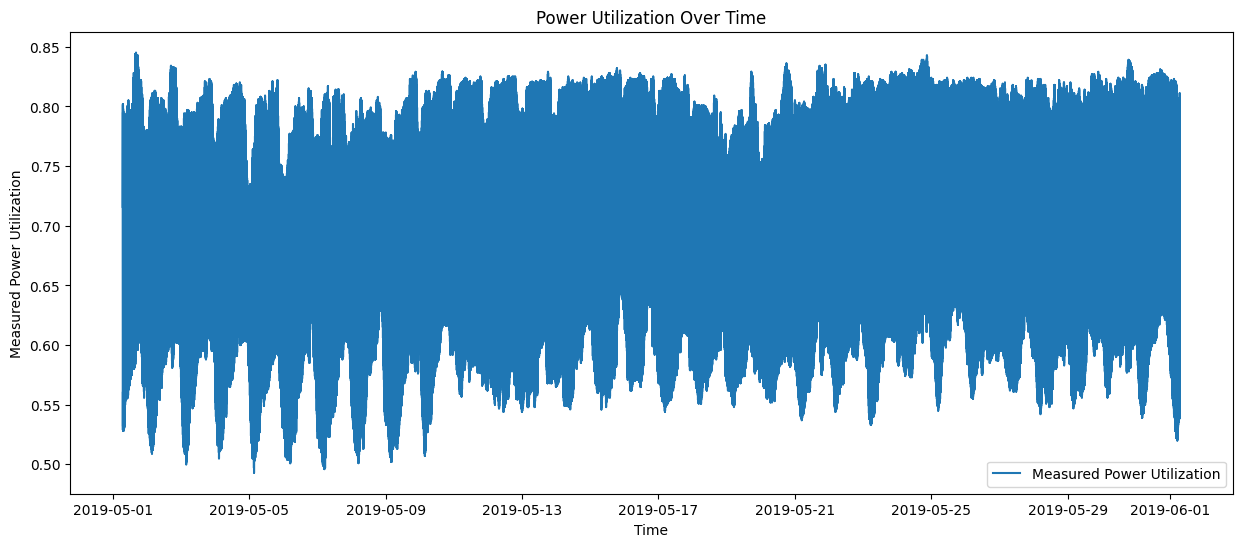

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(power_data['time'], power_data['measured_power_util'], label='Measured Power Utilization')
plt.xlabel('Time')
plt.ylabel('Measured Power Utilization')
plt.title('Power Utilization Over Time')
plt.legend()
plt.show()


In [ ]:
power_data['hour'] = power_data['time'].dt.hour
power_data['day_of_week'] = power_data['time'].dt.dayofweek
power_data['day_of_month'] = power_data['time'].dt.day
power_data['month'] = power_data['time'].dt.month


In [ ]:
power_data.sort_values('time', inplace=True)
power_data['measured_power_util_lag_1'] = power_data['measured_power_util'].shift(1)
power_data['measured_power_util_lag_2'] = power_data['measured_power_util'].shift(2)
power_data['measured_power_util_lag_3'] = power_data['measured_power_util'].shift(3)


In [ ]:
window_size = 3
power_data['measured_power_util_roll_mean'] = power_data['measured_power_util'].rolling(window=window_size).mean()
power_data['measured_power_util_roll_std'] = power_data['measured_power_util'].rolling(window=window_size).std()


In [ ]:

power_data.dropna(inplace=True)


In [ ]:
power_data.shape

(392361, 16)

In [ ]:
power_data.head()

,time,cell,pdu,measured_power_util,production_power_util,bad_measurement_data,bad_production_power_data,hour,day_of_week,day_of_month,month,measured_power_util_lag_1,measured_power_util_lag_2,measured_power_util_lag_3,measured_power_util_roll_mean,measured_power_util_roll_std
25,2019-05-01 07:00:00,a,pdu9,0.715,0.609,False,False,7,2,1,5,0.695,0.596,0.560,0.668667,0.063721
26,2019-05-01 07:00:00,d,pdu34,0.622,0.557,False,False,7,2,1,5,0.715,0.695,0.596,0.677333,0.048952
27,2019-05-01 07:00:00,e,pdu30,0.694,0.606,False,False,7,2,1,5,0.622,0.715,0.695,0.677000,0.048775
28,2019-05-01 07:00:00,e,pdu27,0.688,0.598,False,False,7,2,1,5,0.694,0.622,0.715,0.668000,0.039950
29,2019-05-01 07:00:00,b,pdu11,0.730,0.647,False,False,7,2,1,5,0.688,0.694,0.622,0.704000,0.022716


# I will first use measured_power_util as feature for LSTM and STATING CLEARLY , i am not using standard MLOPS methods to have best models , due to shortgae of time

In [ ]:
power_data.columns

Index(['time', 'cell', 'pdu', 'measured_power_util', 'production_power_util',
       'bad_measurement_data', 'bad_production_power_data', 'hour',
       'day_of_week', 'day_of_month', 'month', 'measured_power_util_lag_1',
       'measured_power_util_lag_2', 'measured_power_util_lag_3',
       'measured_power_util_roll_mean', 'measured_power_util_roll_std'],
      dtype='object')

In [ ]:
features = ['measured_power_util']
data_single_feature = power_data[features]


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_single_feature_scaled = scaler.fit_transform(data_single_feature)


In [ ]:
import numpy as np

def create_sequences(data, time_steps=30):
    sequences = []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:(i + time_steps)])
    return np.array(sequences)

TIME_STEPS = 30
X = create_sequences(data_single_feature_scaled, TIME_STEPS)


In [ ]:
train_size = int(X.shape[0] * 0.7)
X_train = X[:train_size]
X_test = X[train_size:]


In [ ]:

model = Sequential([
    LSTM(64, activation='relu', input_shape=(TIME_STEPS, X.shape[2]), return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    RepeatVector(TIME_STEPS),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(X.shape[2]))
])

model.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

history = model.fit(
    X_train, X_train,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping],
    shuffle=False
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 82s 18ms/step - loss: 0.0362 - val_loss: 0.0258
Epoch 2/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 65s 15ms/step - loss: 0.0256 - val_loss: 0.0206
Epoch 3/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 61s 16ms/step - loss: 0.0214 - val_loss: 0.0178
Epoch 4/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - loss: 0.0185 - val_loss: 0.0157
Epoch 5/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - loss: 0.0163 - val_loss: 0.0146
Epoch 6/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 61s 16ms/step - loss: 0.0167 - val_loss: 0.0141
Epoch 7/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 81s 16ms/step - loss: 0.0143 - val_loss: 0.0118
Epoch 8/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - loss: 0.0126 - val_loss: 0.0103
Epoch 9/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - loss: 0.0116 - val_loss: 0.0101
Epoch 10/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - loss: 0.0113 - val_loss: 0.0100
Epoch 11/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 60s 16ms/step - loss: 0.0149 - val_loss: 0.0102
Epoch 12

Validation loss which is mse started diverge after 13 epochs.

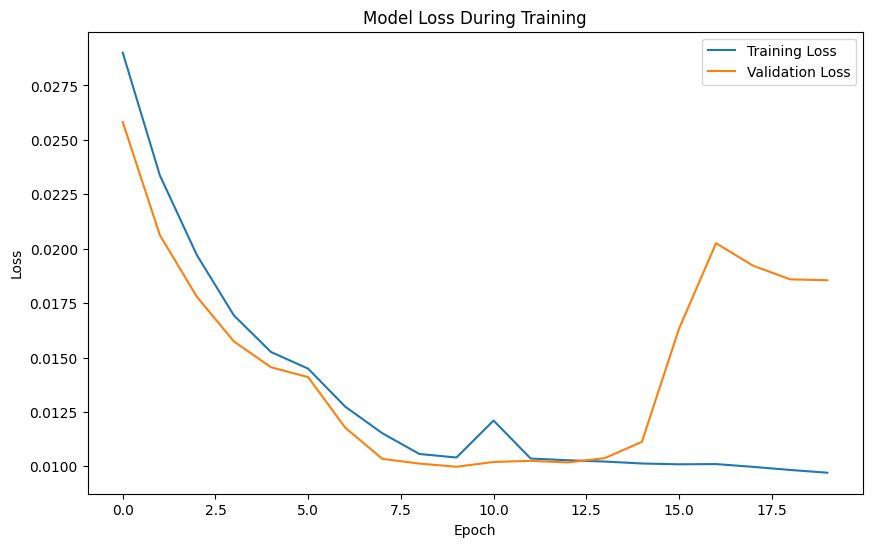

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:

X_test_pred = model.predict(X_test)

test_mse = np.mean(np.power(X_test_pred - X_test, 2), axis=(1, 2))

error_df = pd.DataFrame({'reconstruction_error': test_mse})


3679/3679 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step


In [ ]:

threshold = np.percentile(error_df['reconstruction_error'], 95)

error_df['anomaly'] = error_df['reconstruction_error'] > threshold


In [ ]:

test_time_index = power_data['time'].iloc[train_size + TIME_STEPS:]

error_df = error_df.iloc[:len(test_time_index)].copy()

error_df['time'] = test_time_index.values


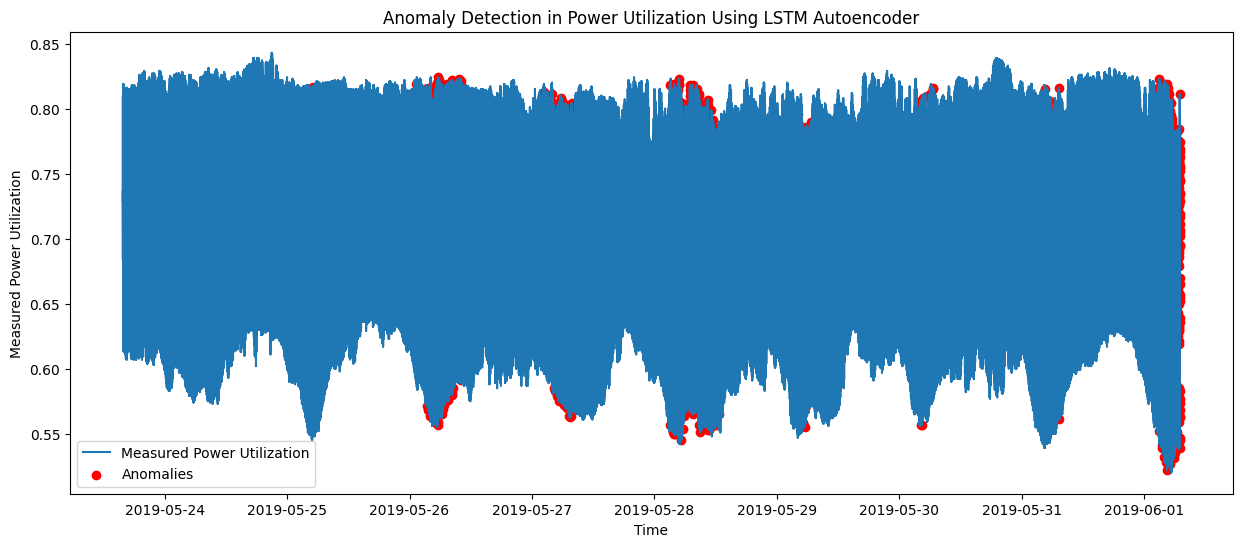

In [ ]:

test_results = power_data.iloc[train_size + TIME_STEPS:].copy()
test_results = test_results.iloc[:len(error_df)].copy()
test_results['reconstruction_error'] = error_df['reconstruction_error'].values
test_results['anomaly'] = error_df['anomaly'].values

plt.figure(figsize=(15, 6))
plt.plot(test_results['time'], test_results['measured_power_util'], label='Measured Power Utilization')
plt.scatter(
    test_results['time'][test_results['anomaly']],
    test_results['measured_power_util'][test_results['anomaly']],
    color='red',
    label='Anomalies'
)
plt.xlabel('Time')
plt.ylabel('Measured Power Utilization')
plt.title('Anomaly Detection in Power Utilization Using LSTM Autoencoder')
plt.legend()
plt.show()


In [ ]:

reconstruction_errors = error_df['reconstruction_error']

mean_re = np.mean(reconstruction_errors)
std_re = np.std(reconstruction_errors)
k = 3
threshold = mean_re + k * std_re

print('Anomaly detection threshold:', threshold)


Anomaly detection threshold: 0.05935692366697807


In [ ]:

error_df['anomaly'] = error_df['reconstruction_error'] > threshold

num_anomalies = error_df['anomaly'].sum()
print('Number of anomalies detected:', num_anomalies)


Number of anomalies detected: 840


In [ ]:

threshold = np.percentile(reconstruction_errors, 95)


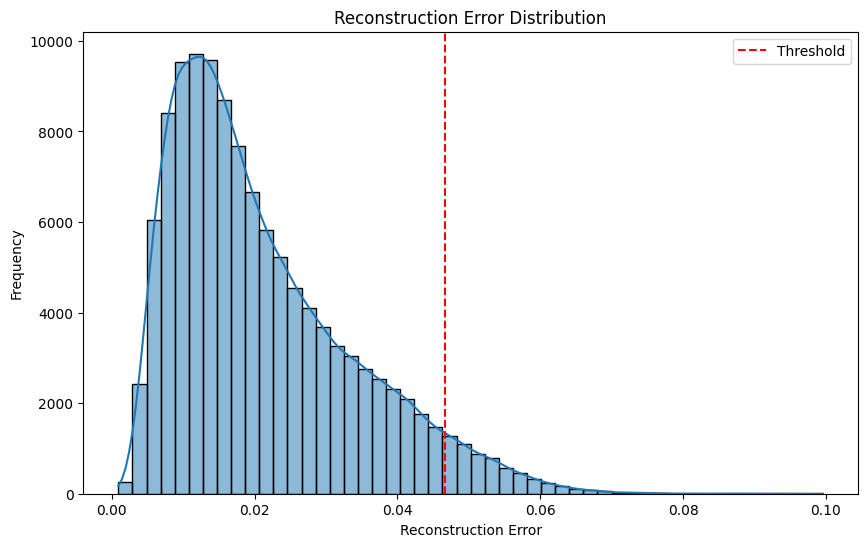

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(reconstruction_errors, bins=50, kde=True)
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()


**Transformer Time variant with single feature**

In [ ]:

train_size = int(X.shape[0] * 0.7)
X_train = X[:train_size]
X_test = X[train_size:]


X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to("cuda")
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to("cuda")

train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)


In [ ]:
# PositionalEncoding class
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Match the sequence length of the input
        x = x + self.pe[:x.size(1), :].unsqueeze(0).to(x.device)
        return self.dropout(x)

class ForecastingModel(nn.Module):
    def __init__(self,
                 seq_len=30,
                 embed_size=16,
                 nhead=4,
                 dim_feedforward=2048,
                 dropout=0.1,
                 device="cuda"):
        super(ForecastingModel, self).__init__()

        self.device = device
        self.embed_size = embed_size
        self.seq_len = seq_len

        # Input Embedding
        self.input_embedding = nn.Linear(1, embed_size)

        # Positional Encoder
        self.position_encoder = PositionalEncoding(d_model=embed_size,
                                                   dropout=dropout,
                                                   max_len=seq_len)

        # Transformer Encoder Layer
        self.transformer_encoder = nn.TransformerEncoderLayer(
            d_model=embed_size,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )

        # Regression Layers
        self.fc1 = nn.Linear(seq_len * embed_size, dim_feedforward)
        self.fc2 = nn.Linear(dim_feedforward, dim_feedforward // 2)
        self.outlayer = nn.Linear(dim_feedforward // 2, seq_len)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        src_mask = self._generate_square_subsequent_mask().to(self.device)
        x = self.input_embedding(x)
        x = self.position_encoder(x)
        x = self.transformer_encoder(x, src_mask=src_mask).reshape((-1, self.seq_len * self.embed_size))
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        return self.outlayer(x)

    def _generate_square_subsequent_mask(self):
        return torch.triu(
            torch.full((self.seq_len, self.seq_len), float('-inf'), dtype=torch.float32, device=self.device),
            diagonal=1,
        )

model = ForecastingModel(seq_len=30, embed_size=16, device="cuda").to("cuda")
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 50
for epoch in range(epochs):
    model.train()
    for inputs, _ in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, inputs.view(outputs.size(0), -1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


Epoch [1/50], Loss: 0.0017
Epoch [2/50], Loss: 0.0013
Epoch [3/50], Loss: 0.0006
Epoch [4/50], Loss: 0.0007
Epoch [5/50], Loss: 0.0005
Epoch [6/50], Loss: 0.0003
Epoch [7/50], Loss: 0.0004
Epoch [8/50], Loss: 0.0004
Epoch [9/50], Loss: 0.0004
Epoch [10/50], Loss: 0.0003
Epoch [11/50], Loss: 0.0003
Epoch [12/50], Loss: 0.0003
Epoch [13/50], Loss: 0.0003
Epoch [14/50], Loss: 0.0004
Epoch [15/50], Loss: 0.0003


KeyboardInterrupt: 

# Transformer Based Time Series Model has impressive MSE

In [ ]:
 # Reduce batch size to 1 during inference
test_loader = DataLoader(TensorDataset(X_test_tensor), batch_size=1, shuffle=False)

model.eval()
X_test_pred = []

with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0]
        outputs = model(inputs).cpu().numpy()
        X_test_pred.append(outputs)

X_test_pred = np.concatenate(X_test_pred, axis=0)

X_test_pred = X_test_pred.reshape(X_test.shape)

test_mse = np.mean(np.power(X_test_pred - X_test, 2), axis=(1, 2))  # Ensure both arrays have the same shape
error_df = pd.DataFrame({'reconstruction_error': test_mse})

mean_re = np.mean(error_df['reconstruction_error'])
std_re = np.std(error_df['reconstruction_error'])
k = 3
threshold = mean_re + k * std_re
print('Anomaly detection threshold:', threshold)

error_df['anomaly'] = error_df['reconstruction_error'] > threshold

test_time_index = power_data.index[TIME_STEPS + train_size:]

error_df = error_df.iloc[:len(test_time_index)].copy()

error_df['time'] = test_time_index.values

test_results = power_data.iloc[TIME_STEPS + train_size:].copy()
test_results = test_results.iloc[:len(error_df)].copy()
test_results['reconstruction_error'] = error_df['reconstruction_error'].values
test_results['anomaly'] = error_df['anomaly'].values

num_anomalies = error_df['anomaly'].sum()
print('Number of anomalies detected:', num_anomalies)


Anomaly detection threshold: 0.0006627655317628453
Number of anomalies detected: 1650


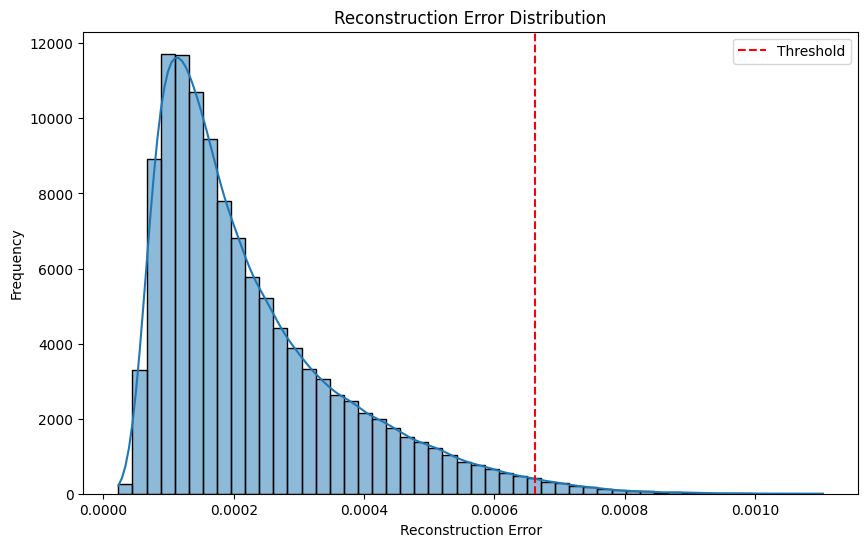

In [ ]:

plt.figure(figsize=(10, 6))
sns.histplot(error_df['reconstruction_error'], bins=50, kde=True)
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()


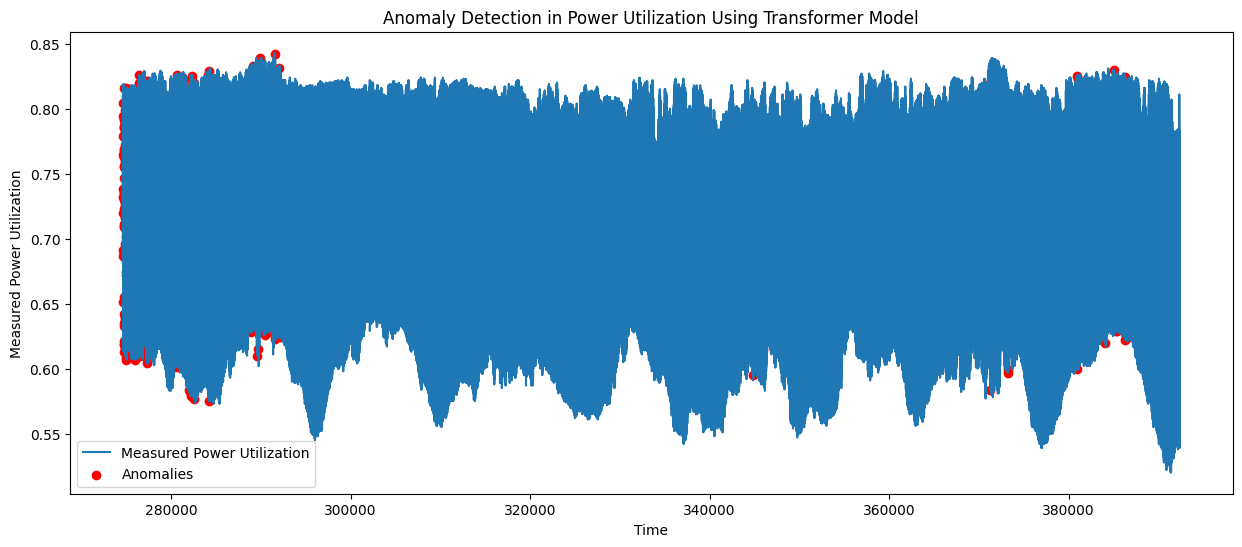

In [ ]:

plt.figure(figsize=(15, 6))
plt.plot(test_results.index, test_results['measured_power_util'], label='Measured Power Utilization')
plt.scatter(
    test_results.index[test_results['anomaly']],
    test_results['measured_power_util'][test_results['anomaly']],
    color='red',
    label='Anomalies'
)
plt.xlabel('Time')
plt.ylabel('Measured Power Utilization')
plt.title('Anomaly Detection in Power Utilization Using Transformer Model')
plt.legend()
plt.show()


**Both LSTM AND Transformer have impressive performance but transformer has extremly Low MSE , indicating impressive accuarcy**

In [ ]:
power_data.columns

Index(['time', 'cell', 'pdu', 'measured_power_util', 'production_power_util',
       'bad_measurement_data', 'bad_production_power_data', 'hour',
       'day_of_week', 'day_of_month', 'month', 'measured_power_util_lag_1',
       'measured_power_util_lag_2', 'measured_power_util_lag_3',
       'measured_power_util_roll_mean', 'measured_power_util_roll_std'],
      dtype='object')

# LSTM and Tansformer Based Time Series MOdel with Multifeature

Columns to be used in this
    'measured_power_util', 'measured_power_util_lag_1', 'measured_power_util_lag_2',
    'measured_power_util_lag_3', 'measured_power_util_roll_mean',
    'measured_power_util_roll_std', 'hour', 'day_of_week'

# LSTM with MultiFeatures

In [ ]:

features = [
    'measured_power_util', 'measured_power_util_lag_1', 'measured_power_util_lag_2',
    'measured_power_util_lag_3', 'measured_power_util_roll_mean',
    'measured_power_util_roll_std', 'hour', 'day_of_week'
]
power_data = power_data.sort_index()

power_data = power_data.dropna()

scaler = MinMaxScaler()
data_Multifeature_scaled = scaler.fit_transform(power_data[features])


In [ ]:

def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

TIME_STEPS = 30
X, y = create_sequences(data_Multifeature_scaled, TIME_STEPS)

train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    RepeatVector(TIME_STEPS),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(X_train.shape[2]))
])
model.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

history = model.fit(
    X_train, X_train,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping],
    shuffle=False
)



Epoch 1/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 92s 21ms/step - loss: 0.0300 - val_loss: 0.0505
Epoch 2/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 65s 17ms/step - loss: 0.0277 - val_loss: 0.0379
Epoch 3/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - loss: 0.0265 - val_loss: 0.0431
Epoch 4/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - loss: 0.0258 - val_loss: 0.0259
Epoch 5/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 83s 17ms/step - loss: 0.0235 - val_loss: 0.0260
Epoch 6/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 83s 17ms/step - loss: 0.0218 - val_loss: 0.0253
Epoch 7/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 79s 16ms/step - loss: 0.0222 - val_loss: 0.0376
Epoch 8/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 84s 17ms/step - loss: 0.0218 - val_loss: 0.0303
Epoch 9/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 81s 17ms/step - loss: 0.0228 - val_loss: 0.0262
Epoch 10/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 82s 17ms/step - loss: 0.0212 - val_loss: 0.0243
Epoch 11/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 81s 16ms/step - loss: 0.0214 - val_loss: 0.0233
Epoch 12

KeyboardInterrupt: 

# stopped traing . MSE is not converging

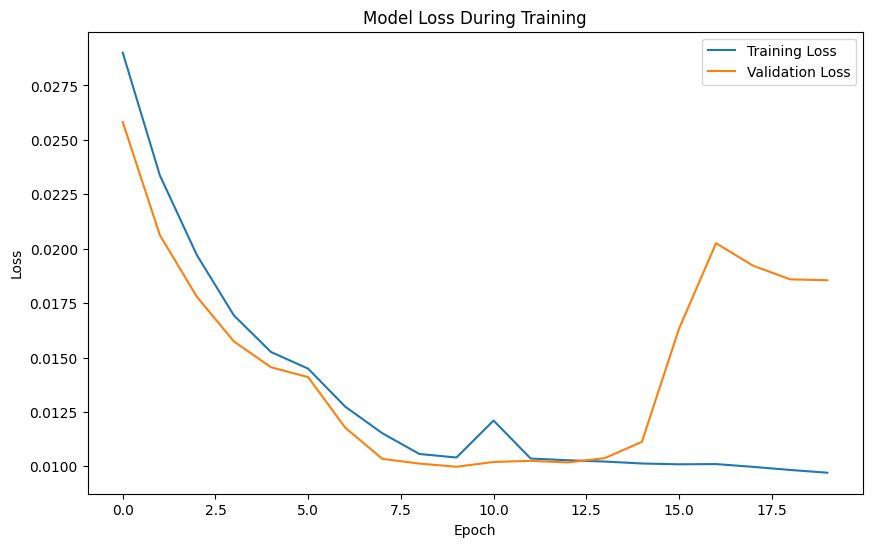

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
X_test_pred = model.predict(X_test)

test_mse = np.mean(np.power(X_test_pred - X_test, 2), axis=(1, 2))
error_df = pd.DataFrame({'reconstruction_error': test_mse})

mean_re = np.mean(error_df['reconstruction_error'])
std_re = np.std(error_df['reconstruction_error'])
k = 3
threshold = mean_re + k * std_re
print('Anomaly detection threshold:', threshold)

error_df['anomaly'] = error_df['reconstruction_error'] > threshold

test_time_index = power_data.index[TIME_STEPS + train_size:]

error_df = error_df.iloc[:len(test_time_index)].copy()

error_df['time'] = test_time_index.values

test_results = power_data.iloc[TIME_STEPS + train_size:].copy()
test_results = test_results.iloc[:len(error_df)].copy()
test_results['reconstruction_error'] = error_df['reconstruction_error'].values
test_results['anomaly'] = error_df['anomaly'].values

num_anomalies = error_df['anomaly'].sum()
print('Number of anomalies detected:', num_anomalies)


3679/3679 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step
Anomaly detection threshold: 0.047292683298378296
Number of anomalies detected: 567


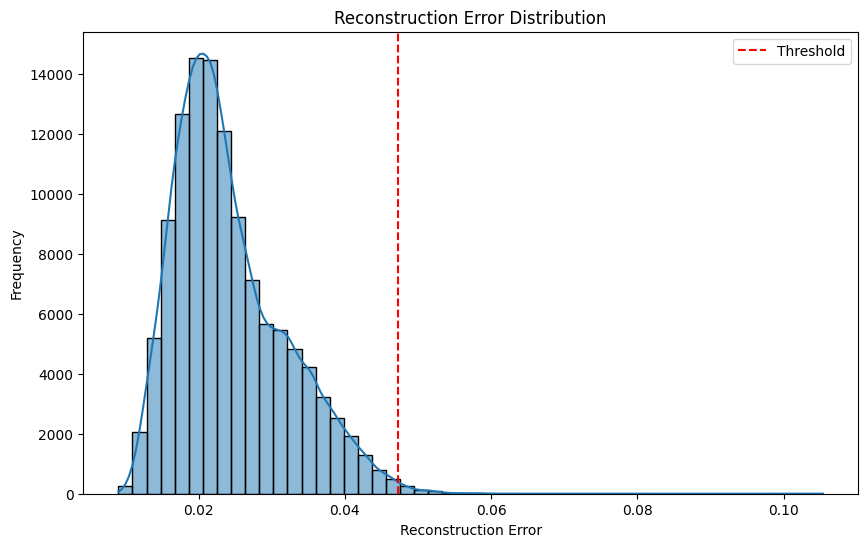

In [ ]:

plt.figure(figsize=(10, 6))
sns.histplot(error_df['reconstruction_error'], bins=50, kde=True)
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

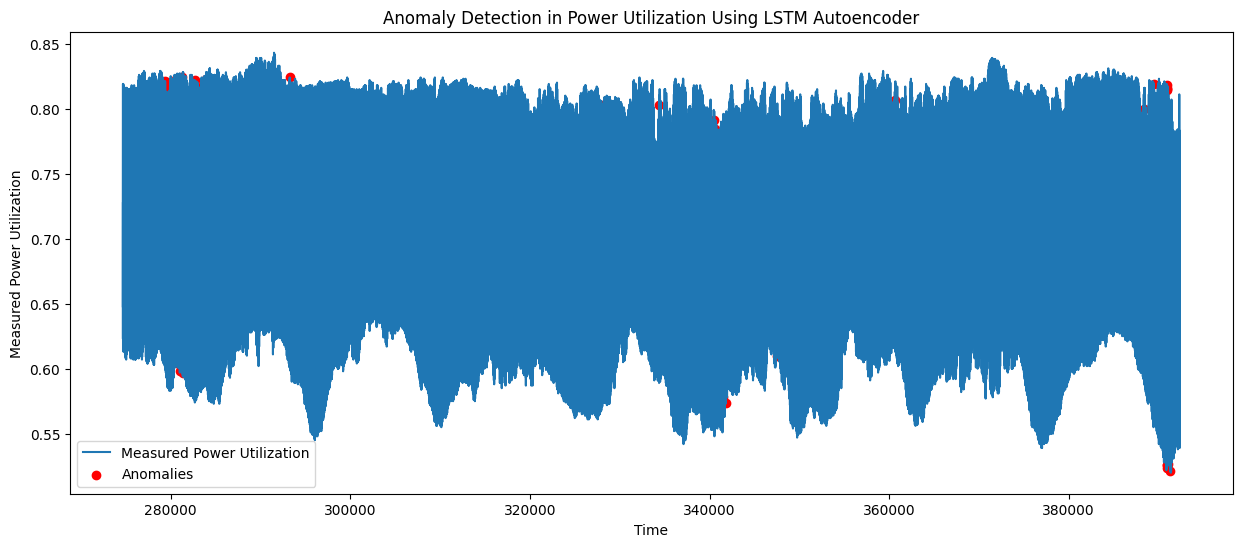

In [ ]:

plt.figure(figsize=(15, 6))
plt.plot(test_results.index, test_results['measured_power_util'], label='Measured Power Utilization')
plt.scatter(
    test_results.index[test_results['anomaly']],
    test_results['measured_power_util'][test_results['anomaly']],
    color='red',
    label='Anomalies'
)
plt.xlabel('Time')
plt.ylabel('Measured Power Utilization')
plt.title('Anomaly Detection in Power Utilization Using LSTM Autoencoder')
plt.legend()
plt.show()


# Time Series Tranformer varaint with Multifeature

In [ ]:


X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to("cuda")
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to("cuda")


In [ ]:

class ForecastingModel(nn.Module):
    def __init__(self,
                 seq_len=TIME_STEPS,
                 input_dim=len(features),
                 embed_size=16,
                 nhead=4,
                 dim_feedforward=2048,
                 dropout=0.1,
                 device="cuda"):
        super(ForecastingModel, self).__init__()

        self.device = device
        self.embed_size = embed_size
        self.seq_len = seq_len

        self.input_embedding = nn.Linear(input_dim, embed_size)

        # Positional Encoder
        self.position_encoder = PositionalEncoding(d_model=embed_size,
                                                   dropout=dropout,
                                                   max_len=seq_len)

        # Transformer Encoder Layer
        self.transformer_encoder = nn.TransformerEncoderLayer(
            d_model=embed_size,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )

        # Regression Layers
        self.fc1 = nn.Linear(seq_len * embed_size, dim_feedforward)
        self.fc2 = nn.Linear(dim_feedforward, dim_feedforward // 2)
        self.outlayer = nn.Linear(dim_feedforward // 2, seq_len * input_dim)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        src_mask = self._generate_square_subsequent_mask().to(self.device)
        x = self.input_embedding(x)
        x = self.position_encoder(x)
        x = self.transformer_encoder(x, src_mask=src_mask).reshape((-1, self.seq_len * self.embed_size))
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        return self.outlayer(x).view(-1, self.seq_len, len(features))

    def _generate_square_subsequent_mask(self):
        return torch.triu(
            torch.full((self.seq_len, self.seq_len), float('-inf'), dtype=torch.float32, device=self.device),
            diagonal=1,
        )

model = ForecastingModel(seq_len=TIME_STEPS, embed_size=16, device="cuda").to("cuda")
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:

train_loader = DataLoader(TensorDataset(X_train_tensor, X_train_tensor), batch_size=64, shuffle=False)


epochs = 50
train_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, _ in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss:.4f}")


Epoch [1/50], Training Loss: 0.0229
Epoch [2/50], Training Loss: 0.0221
Epoch [3/50], Training Loss: 0.0224
Epoch [4/50], Training Loss: 0.0226
Epoch [5/50], Training Loss: 0.0232
Epoch [6/50], Training Loss: 0.0231
Epoch [7/50], Training Loss: 0.0233
Epoch [8/50], Training Loss: 0.0234
Epoch [9/50], Training Loss: 0.0246
Epoch [10/50], Training Loss: 0.0308
Epoch [11/50], Training Loss: 0.0437
Epoch [12/50], Training Loss: 0.0439


KeyboardInterrupt: 

# stopped the traing , mse diverges

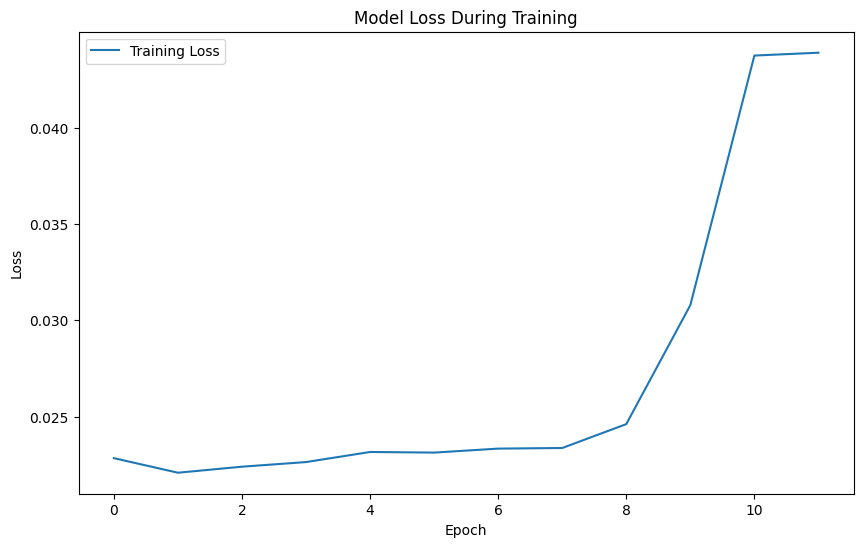

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:

test_loader = DataLoader(TensorDataset(X_test_tensor), batch_size=1, shuffle=False)
model.eval()
X_test_pred = []

with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0]
        outputs = model(inputs).cpu().numpy()
        X_test_pred.append(outputs)

X_test_pred = np.concatenate(X_test_pred, axis=0)

X_test_pred = X_test_pred.reshape(X_test.shape)

test_mse = np.mean(np.power(X_test_pred - X_test, 2), axis=(1, 2))
error_df = pd.DataFrame({'reconstruction_error': test_mse})

mean_re = np.mean(error_df['reconstruction_error'])
std_re = np.std(error_df['reconstruction_error'])
k = 3
threshold = mean_re + k * std_re
print('Anomaly detection threshold:', threshold)

error_df['anomaly'] = error_df['reconstruction_error'] > threshold


test_time_index = power_data.index[TIME_STEPS + train_size:]

error_df = error_df.iloc[:len(test_time_index)].copy()

error_df['time'] = test_time_index.values

test_results = power_data.iloc[TIME_STEPS + train_size:].copy()
test_results = test_results.iloc[:len(error_df)].copy()
test_results['reconstruction_error'] = error_df['reconstruction_error'].values
test_results['anomaly'] = error_df['anomaly'].values

num_anomalies = error_df['anomaly'].sum()
print('Number of anomalies detected:', num_anomalies)


Anomaly detection threshold: 0.10973716278534287
Number of anomalies detected: 253


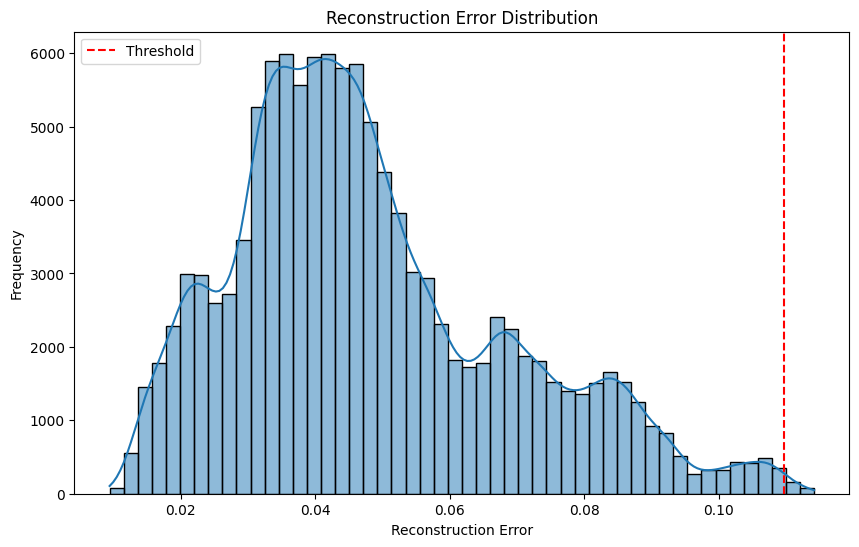

In [ ]:

plt.figure(figsize=(10, 6))
sns.histplot(error_df['reconstruction_error'], bins=50, kde=True)
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()


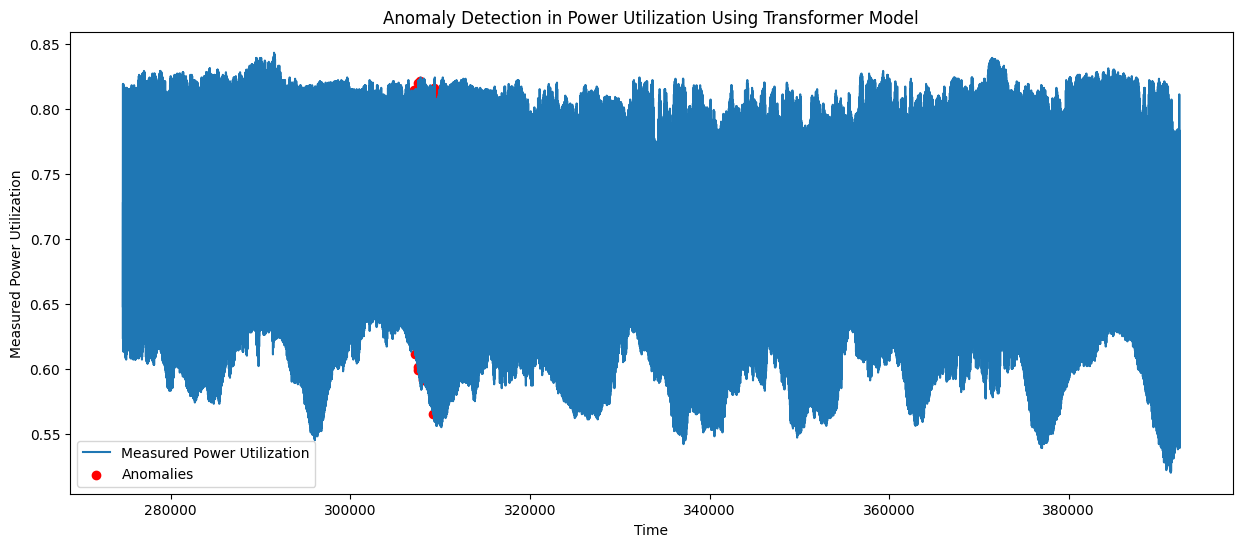

In [ ]:

plt.figure(figsize=(15, 6))
plt.plot(test_results.index, test_results['measured_power_util'], label='Measured Power Utilization')
plt.scatter(
    test_results.index[test_results['anomaly']],
    test_results['measured_power_util'][test_results['anomaly']],
    color='red',
    label='Anomalies'
)
plt.xlabel('Time')
plt.ylabel('Measured Power Utilization')
plt.title('Anomaly Detection in Power Utilization Using Transformer Model')
plt.legend()
plt.show()


**Both LSTM and Transformer MSE value are not converging fort multi fedatures .
# **IT shouws that only power utilzation is important in anamoly detection**

# CLassical models

In [ ]:

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd


features = ['measured_power_util']
data = power_data[features]

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

def create_sequences(data, time_steps=30):
    sequences = []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:(i + time_steps)])
    return np.array(sequences)


TIME_STEPS = 30
X = create_sequences(data_scaled, TIME_STEPS)

X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)


decision_tree = DecisionTreeRegressor(random_state=42)
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

decision_tree.fit(X_train_reshaped, X_train_reshaped[:, 0])
dt_predictions = decision_tree.predict(X_test_reshaped)

random_forest.fit(X_train_reshaped, X_train_reshaped[:, 0])
rf_predictions = random_forest.predict(X_test_reshaped)

dt_reconstruction_error = mean_squared_error(X_test_reshaped[:, 0], dt_predictions)
rf_reconstruction_error = mean_squared_error(X_test_reshaped[:, 0], rf_predictions)

print(f"Decision Tree Reconstruction Error: {dt_reconstruction_error}")
print(f"Random Forest Reconstruction Error: {rf_reconstruction_error}")


Decision Tree Reconstruction Error: 9.599889760352244e-10
Random Forest Reconstruction Error: 8.923371814811272e-10


In [ ]:
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
dt_reconstruction_errors = np.abs(X_test_reshaped[:, 0] - dt_predictions)
rf_reconstruction_errors = np.abs(X_test_reshaped[:, 0] - rf_predictions)

error_df_dt = pd.DataFrame({'reconstruction_error': dt_reconstruction_errors, 'model': 'Decision Tree'})
error_df_rf = pd.DataFrame({'reconstruction_error': rf_reconstruction_errors, 'model': 'Random Forest'})


error_df_combined = pd.concat([error_df_dt, error_df_rf], ignore_index=True)


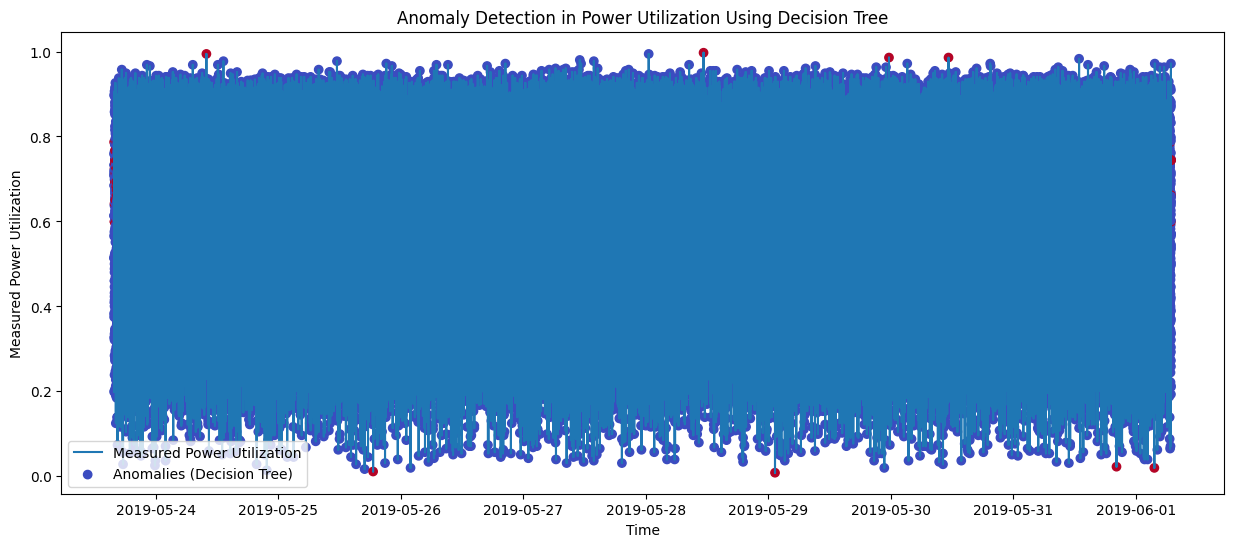

In [ ]:
import matplotlib.pyplot as plt

# Retrieve the time column for the test set
test_indices = X_test.reshape(X_test.shape[0], TIME_STEPS, -1)  # Reshape test set to original sequence shape
test_time_index = power_data['time'].iloc[-len(test_indices):].values  # Align time with test set indices

# Calculate reconstruction errors for the Decision Tree
dt_reconstruction_errors = np.power(X_test_reshaped[:, 0] - dt_predictions, 2)

# Plot reconstruction errors for Decision Tree
plt.figure(figsize=(15, 6))
plt.plot(test_time_index, X_test_reshaped[:, 0], label='Measured Power Utilization')
plt.scatter(
    test_time_index,
    X_test_reshaped[:, 0],
    c=(dt_reconstruction_errors > error_threshold),  # Flag anomalies where error exceeds threshold
    cmap='coolwarm',  # Color anomalies differently
    label='Anomalies (Decision Tree)'
)
plt.xlabel('Time')
plt.ylabel('Measured Power Utilization')
plt.title('Anomaly Detection in Power Utilization Using Decision Tree')
plt.legend()
plt.show()


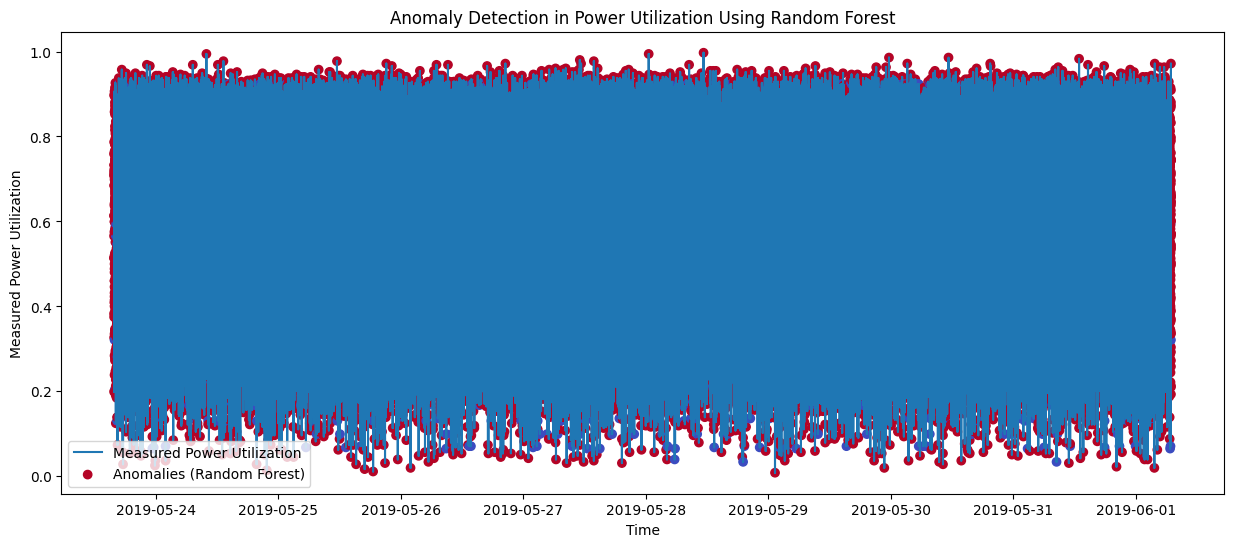

In [ ]:

plt.figure(figsize=(15, 6))
plt.plot(test_time_index, X_test_reshaped[:, 0], label='Measured Power Utilization')
plt.scatter(
    test_time_index,
    X_test_reshaped[:, 0],
    c=(rf_reconstruction_errors > error_threshold),
    cmap='coolwarm',
    label='Anomalies (Random Forest)'
)
plt.xlabel('Time')
plt.ylabel('Measured Power Utilization')
plt.title('Anomaly Detection in Power Utilization Using Random Forest')
plt.legend()
plt.show()


# CLassical models have confused outlier and anamolies . as shwon in gthe graph